Features after VarianceThreshold: ['RBC', 'Hb', 'MCV', 'MCH', 'MCHC', 'HCT', 'RDW-CV', 'BP', 'Cholesterol', 'Diabetes', 'Age', 'Gender']
Selected Features (Embedded Method): ['RBC', 'MCV', 'MCHC', 'HCT', 'RDW-CV', 'Age']

Accuracy: 74.38%
ROC AUC Score: 80.45%

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.70      0.73        80
           1       0.72      0.79      0.75        80

    accuracy                           0.74       160
   macro avg       0.75      0.74      0.74       160
weighted avg       0.75      0.74      0.74       160


Predictions saved to predictions_embedded_method.csv

Training class distribution:
 Heartdisease
0    0.5
1    0.5
Name: proportion, dtype: float64
Test class distribution:
 Heartdisease
1    0.5
0    0.5
Name: proportion, dtype: float64


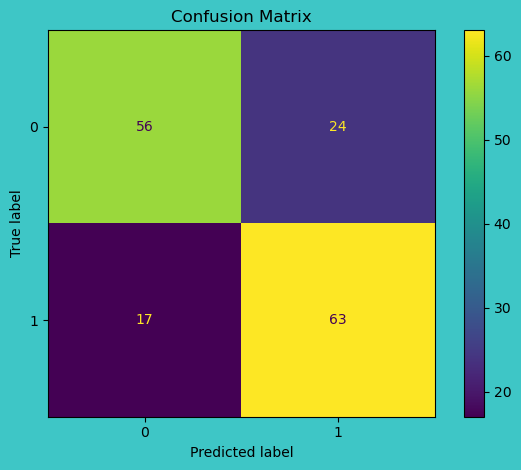

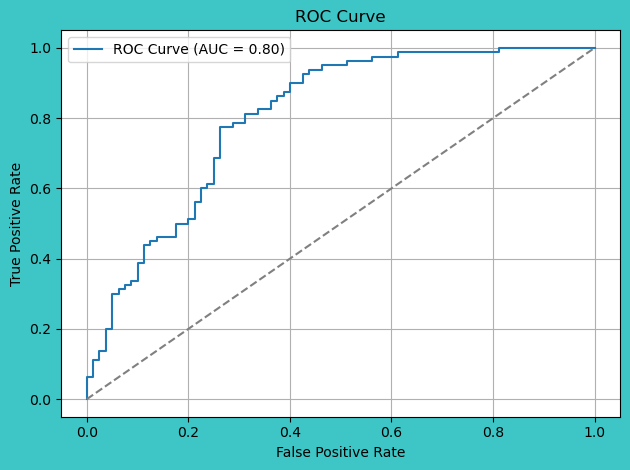

In [3]:
#LR

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve

# Load data
data = pd.read_csv("actualdata.csv")
data = data.dropna(subset=['Heartdisease'])

# Encode Gender (0=F, 1=M)
if data['Gender'].dtype == object:
    data['Gender'] = LabelEncoder().fit_transform(data['Gender'])

# Map BP, Cholesterol, Diabetes to 0/1
for col in ['BP', 'Cholesterol', 'Diabetes']:
    if data[col].dtype == object:
        data[col] = data[col].map({'Yes': 1, 'No': 0})

# Anemia logic
def is_anemic(row):
    age, hb, gender = row['Age'], row['Hb'], row['Gender']
    if age < 5:
        return hb < 11.0
    elif 5 <= age <= 11:
        return hb < 11.5
    else:
        return hb < (12.0 if gender == 0 else 13.0)

data['Anemia'] = data.apply(is_anemic, axis=1)
data['Anemia'] = data['Anemia'].map({True: 'Yes', False: 'No'})

def classify_anemia_severity(hb, age, gender):
    threshold = 11.0 if age < 5 else 11.5 if age <= 11 else (12.0 if gender == 0 else 13.0)
    if hb < 8.0:
        return 'Severe'
    elif 8.0 <= hb <= 10.9:
        return 'Moderate'
    elif 11.0 <= hb < threshold:
        return 'Mild'
    return 'None'

data['Anemia_Severity'] = data.apply(
    lambda row: classify_anemia_severity(row['Hb'], row['Age'], row['Gender']),
    axis=1
)

# Feature selection
features = ['RBC', 'Hb', 'MCV', 'MCH', 'MCHC', 'HCT', 'RDW-CV',
            'BP', 'Cholesterol', 'Diabetes', 'Age', 'Gender']
scaler = MinMaxScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data[features]), columns=features, index=data.index)

X = data_scaled
y = data['Heartdisease']

# Data split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# --- START OF MODIFIED SECTION ---

# Remove constant features
var_thresh = VarianceThreshold(threshold=0)
X_train_var = var_thresh.fit_transform(X_train)
X_test_var = var_thresh.transform(X_test)

features_kept = [feature for feature, keep in zip(features, var_thresh.get_support()) if keep]
X_train_df = pd.DataFrame(X_train_var, columns=features_kept, index=X_train.index)
X_test_df = pd.DataFrame(X_test_var, columns=features_kept, index=X_test.index)


# Define the embedded feature selection method and the final classifier in a Pipeline
# We use RandomForestClassifier to determine feature importances, then a LogisticRegression model.
rf_estimator = RandomForestClassifier(n_estimators=100, random_state=42)
selector_embedded = SelectFromModel(rf_estimator, threshold="median")
model_embedded = LogisticRegression(max_iter=1000, random_state=42)

pipeline_embedded = Pipeline(steps=[
    ('feature_selection', selector_embedded),
    ('classifier', model_embedded)
])

# Fit the entire pipeline on the data
pipeline_embedded.fit(X_train_df, y_train)

# Extract selected features for printing
selected_features_indices = pipeline_embedded.named_steps['feature_selection'].get_support(indices=True)
selected_features = [features_kept[i] for i in selected_features_indices]

print(f"Features after VarianceThreshold: {features_kept}")
print(f"Selected Features (Embedded Method): {selected_features}\n")


# Predict using the fitted pipeline
predicted_proba = pipeline_embedded.predict_proba(X_test_df)[:, 1]
predicted_proba_percent = predicted_proba * 100
predicted_class = (predicted_proba >= 0.5).astype(int)

# --- END OF MODIFIED SECTION ---

# Evaluation
accuracy = accuracy_score(y_test, predicted_class)
roc_auc = roc_auc_score(y_test, predicted_proba)

# Round accuracy and ROC AUC for printing to nearest whole number
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"ROC AUC Score: {roc_auc * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, predicted_class, zero_division=0))

# Predictions DataFrame
predictions_df = pd.DataFrame({
    'Predicted_Class': predicted_class,
    'Predicted_Probability(%)': predicted_proba_percent
}, index=X_test.index)

# Enrich with original features
predictions_df['Cholesterol'] = data.loc[X_test.index, 'Cholesterol'].map({1: 'Yes', 0: 'No'})
predictions_df['Diabetes'] = data.loc[X_test.index, 'Diabetes'].map({1: 'Yes', 0: 'No'})
predictions_df['BP'] = data.loc[X_test.index, 'BP'].map({1: 'Yes', 0: 'No'})
predictions_df['Anemia_Severity'] = data.loc[X_test.index, 'Anemia_Severity']
predictions_df['Anemia'] = data.loc[X_test.index, 'Anemia']


# Save predictions
predictions_df.to_csv('predictions_embedded_method.csv')
print("\nPredictions saved to predictions_embedded_method.csv")


# Class distribution
print("\nTraining class distribution:\n", y_train.value_counts(normalize=True))
print("Test class distribution:\n", y_test.value_counts(normalize=True))

# Confusion matrix
cm = confusion_matrix(y_test, predicted_class)
fig, ax = plt.subplots()
fig.patch.set_facecolor('#3ec6c6')
ax.set_facecolor('#3ec6c6')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax, cmap='viridis')
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, predicted_proba)
plt.figure(facecolor='#3ec6c6')
ax = plt.gca()
ax.set_facecolor('white')
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



Total dataset size: 800
Missing target values: 0
Features kept after removing constant features: ['RBC', 'Hb', 'MCV', 'MCH', 'MCHC', 'HCT', 'RDW-CV', 'BP', 'Cholesterol', 'Diabetes', 'Age', 'Gender']

--- Embedded Method (SelectFromModel) with Tuned Decision Tree ---
Fitting 5 folds for each of 480 candidates, totalling 2400 fits
Best parameters for Embedded Method: {'classifier__criterion': 'entropy', 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 20, 'classifier__min_samples_split': 2, 'feature_selection__threshold': 0.1}
Best ROC AUC score from GridSearchCV: 0.7994
Selected features with Embedded Method: ['RDW-CV', 'Age']
Accuracy: 73.75%
ROC AUC Score: 76.12%

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.59      0.69        80
           1       0.68      0.89      0.77        80

    accuracy                           0.74       160
   macro avg       0.76      0.74      0.73       160
weighted avg      

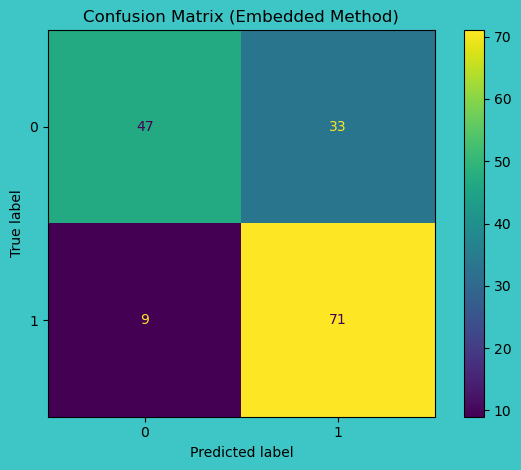

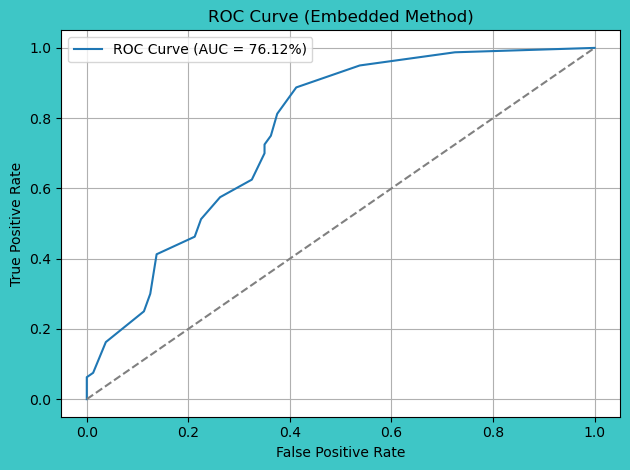

In [7]:
#DT without SMOTE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, roc_curve, ConfusionMatrixDisplay
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

# Load data
data = pd.read_csv("actualdata.csv")

# Drop rows with missing target
data = data.dropna(subset=['Heartdisease'])

# Encode Gender (0=F, 1=M)
if data['Gender'].dtype == object:
    data['Gender'] = LabelEncoder().fit_transform(data['Gender'])

# Map BP, Cholesterol, Diabetes to 0/1
for col in ['BP', 'Cholesterol', 'Diabetes']:
    if data[col].dtype == object:
        data[col] = data[col].map({'Yes': 1, 'No': 0})

# Define anemia based on gender and age
def is_anemic(row):
    age = row['Age']
    hb = row['Hb']
    gender = row['Gender']

    if age < 5:
        return hb < 11.0
    elif 5 <= age <= 11:
        return hb < 11.5
    else:  # age >= 12
        if gender == 0:  # Female
            return hb < 12.0
        elif gender == 1:  # Male
            return hb < 13.0
        else:
            return False  # handle unknown gender

data['Anemia'] = data.apply(is_anemic, axis=1)
data['Anemia'] = data['Anemia'].map({True: 'Yes', False: 'No'})

# Anemia severity classification
def classify_anemia_severity(hb, age, gender):
    # Determine threshold based on age and gender
    if age < 5:
        threshold = 11.0
    elif 5 <= age <= 11:
        threshold = 11.5
    else:
        threshold = 12.0 if gender == 0 else 13.0

    if hb < 8.0:
        return 'Severe'
    elif 8.0 <= hb <= 10.9:
        return 'Moderate'
    elif hb >= 11.0 and hb < threshold:
        return 'Mild'
    else:
        return 'None'

data['Anemia_Severity'] = data.apply(
    lambda row: classify_anemia_severity(row['Hb'], row['Age'], row['Gender']),
    axis=1
)

# Normalize selected features for modeling
features = ['RBC', 'Hb', 'MCV', 'MCH', 'MCHC', 'HCT', 'RDW-CV',
            'BP', 'Cholesterol', 'Diabetes', 'Age', 'Gender']
scaler = MinMaxScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data[features]), columns=features, index=data.index)

# Prepare features and target
X = data_scaled
y = data['Heartdisease']

print("Total dataset size:", len(data))
print("Missing target values:", data['Heartdisease'].isna().sum())

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Remove constant features
var_thresh = VarianceThreshold(threshold=0)
X_train_var = var_thresh.fit_transform(X_train)
X_test_var = var_thresh.transform(X_test)

features_kept = [feature for feature, keep in zip(features, var_thresh.get_support()) if keep]
print("Features kept after removing constant features:", features_kept)

# --- START OF MODIFIED SECTION FOR EMBEDDED METHOD (SelectFromModel) ---
print("\n--- Embedded Method (SelectFromModel) with Tuned Decision Tree ---")

# Pipeline with RandomForestClassifier for feature importance and DecisionTreeClassifier for final prediction
pipeline_embedded = Pipeline(steps=[
    ('feature_selection', SelectFromModel(RandomForestClassifier(random_state=42))),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Parameter grid
param_grid_embedded = {
    'feature_selection__threshold': ['mean', 'median', 0.05, 0.1], 
    'classifier__max_depth': [3, 5, 7, 10, None],
    'classifier__min_samples_leaf': [1, 5, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__criterion': ['gini', 'entropy']
}

# GridSearchCV without SMOTE
grid_search_embedded = GridSearchCV(
    pipeline_embedded, 
    param_grid_embedded,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

# Fit on original training data
grid_search_embedded.fit(X_train_var, y_train)

print("Best parameters for Embedded Method:", grid_search_embedded.best_params_)
print(f"Best ROC AUC score from GridSearchCV: {grid_search_embedded.best_score_:.4f}")

# Best pipeline
best_pipeline = grid_search_embedded.best_estimator_

# Selected features
selected_features_indices = best_pipeline.named_steps['feature_selection'].get_support(indices=True)
selected_features = [features_kept[i] for i in selected_features_indices]
print("Selected features with Embedded Method:", selected_features)

# Predict on test
predicted_proba = best_pipeline.predict_proba(X_test_var)[:, 1]

# Convert probabilities to percentages
predicted_proba_percent = predicted_proba * 100

# Threshold for classification
threshold = 0.3
predicted_class = (predicted_proba >= threshold).astype(int)

# Evaluation
accuracy = accuracy_score(y_test, predicted_class) * 100
roc_auc = roc_auc_score(y_test, predicted_proba) * 100

print(f"Accuracy: {accuracy:.2f}%")
print(f"ROC AUC Score: {roc_auc:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, predicted_class, zero_division=0))

# Prepare predictions DataFrame
predictions_df = pd.DataFrame({
    'Predicted_Class': predicted_class,
    'Predicted_Probability(%)': predicted_proba_percent
}, index=X_test.index)

# Map back Cholesterol, Diabetes, BP for test set
predictions_df['Cholesterol'] = data.loc[X_test.index, 'Cholesterol'].map({1: 'Yes', 0: 'No'})
predictions_df['Diabetes'] = data.loc[X_test.index, 'Diabetes'].map({1: 'Yes', 0: 'No'})
predictions_df['BP'] = data.loc[X_test.index, 'BP'].map({1: 'Yes', 0: 'No'})

# Add Anemia Severity and Anemia labels for display (re-calculated)
temp_data_for_display = pd.read_csv("actualdata.csv").loc[X_test.index].copy()

if temp_data_for_display['Gender'].dtype == object:
    temp_data_for_display['Gender'] = LabelEncoder().fit_transform(temp_data_for_display['Gender'])

temp_data_for_display['Anemia_Severity_Display'] = temp_data_for_display.apply(
    lambda row: classify_anemia_severity(row['Hb'], row['Age'], row['Gender']),
    axis=1
)
temp_data_for_display['Anemia_Display'] = temp_data_for_display.apply(is_anemic, axis=1).map({True: 'Yes', False: 'No'})

predictions_df['Anemia_Severity'] = temp_data_for_display['Anemia_Severity_Display']
predictions_df['Anemia'] = temp_data_for_display['Anemia_Display']

# Save predictions
predictions_df.to_csv('predictions_dt_embedded.csv')
print("Predictions saved to predictions_dt_embedded.csv")

# Print class distributions
print("Training class distribution:\n", y_train.value_counts(normalize=True))
print("Test class distribution:\n", y_test.value_counts(normalize=True))

# Confusion matrix
cm = confusion_matrix(y_test, predicted_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

fig, ax = plt.subplots()
fig.patch.set_facecolor('#3ec6c6')
ax.set_facecolor('#3ec6c6')

disp.plot(ax=ax, cmap='viridis')
plt.title("Confusion Matrix (Embedded Method)")
plt.tight_layout()
plt.show()

# ROC curve plot
fpr, tpr, _ = roc_curve(y_test, predicted_proba)

plt.figure(facecolor='#3ec6c6')
ax = plt.gca()
ax.set_facecolor('white')

plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f}%)')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Embedded Method)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



--- Embedded Method (SelectFromModel) with Tuned LightGBM ---
Fitting 5 folds for each of 24 candidates, totalling 120 fits
[LightGBM] [Info] Number of positive: 320, number of negative: 320
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000143 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 913
[LightGBM] [Info] Number of data points in the train set: 640, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

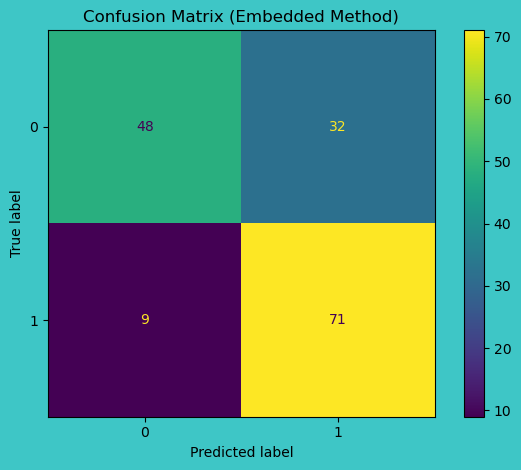

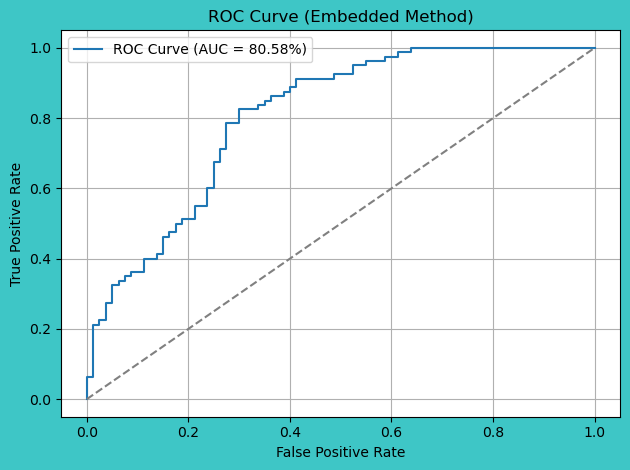

In [5]:
#Light GBM without SMOTE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, roc_curve, ConfusionMatrixDisplay
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline

# Load data
data = pd.read_csv("actualdata.csv")
data = data.dropna(subset=['Heartdisease'])

# Encode Gender (0=F, 1=M)
if data['Gender'].dtype == object:
    data['Gender'] = LabelEncoder().fit_transform(data['Gender'])

# Map BP, Cholesterol, Diabetes
for col in ['BP', 'Cholesterol', 'Diabetes']:
    if data[col].dtype == object:
        data[col] = data[col].map({'Yes': 1, 'No': 0})

# Define Anemia
def is_anemic(row):
    age = row['Age']
    hb = row['Hb']
    gender = row['Gender']
    if age < 5:
        return hb < 11.0
    elif 5 <= age <= 11:
        return hb < 11.5
    else:
        return hb < (12.0 if gender == 0 else 13.0)

data['Anemia'] = data.apply(is_anemic, axis=1).map({True: 'Yes', False: 'No'})

# Classify severity
def classify_anemia_severity(hb, age, gender):
    if age < 5:
        threshold = 11.0
    elif 5 <= age <= 11:
        threshold = 11.5
    else:
        threshold = 12.0 if gender == 0 else 13.0
    if hb < 8.0:
        return 'Severe'
    elif 8.0 <= hb <= 10.9:
        return 'Moderate'
    elif hb >= 11.0 and hb < threshold:
        return 'Mild'
    else:
        return 'None'

data['Anemia_Severity'] = data.apply(
    lambda row: classify_anemia_severity(row['Hb'], row['Age'], row['Gender']), axis=1
)

# Normalize features
features = ['RBC', 'Hb', 'MCV', 'MCH', 'MCHC', 'HCT', 'RDW-CV', 'BP', 'Cholesterol', 'Diabetes', 'Age', 'Gender']
scaler = MinMaxScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data[features]), columns=features, index=data.index)

# Target
X = data_scaled
y = data['Heartdisease']

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Remove constant features
var_thresh = VarianceThreshold(threshold=0)
X_train_var = var_thresh.fit_transform(X_train)
X_test_var = var_thresh.transform(X_test)
features_kept = [f for f, keep in zip(features, var_thresh.get_support()) if keep]
X_train_df = pd.DataFrame(X_train_var, columns=features_kept, index=X_train.index)
X_test_df = pd.DataFrame(X_test_var, columns=features_kept, index=X_test.index)

# --- Embedded method with SelectFromModel and LightGBM ---

print("\n--- Embedded Method (SelectFromModel) with Tuned LightGBM ---")

# Estimator for feature selection
lgbm_selector_estimator = LGBMClassifier(random_state=42, n_estimators=100)
selector_embedded = SelectFromModel(lgbm_selector_estimator, threshold="median")

# Final classifier
classifier_lgbm = LGBMClassifier(random_state=42)

pipeline_embedded = Pipeline(steps=[
    ('feature_selection', selector_embedded),
    ('classifier', classifier_lgbm)
])

# Parameter grid for tuning
param_grid_embedded = {
    'feature_selection__threshold': ['mean', 'median'],
    'classifier__n_estimators': [100, 200, 300],
    'classifier__num_leaves': [15, 31],
    'classifier__learning_rate': [0.05, 0.1]
}

# GridSearchCV without SMOTE
grid_search_embedded = GridSearchCV(
    pipeline_embedded, 
    param_grid_embedded, 
    cv=5, 
    scoring='roc_auc', 
    n_jobs=-1, 
    verbose=1
)
grid_search_embedded.fit(X_train_df, y_train)

print("Best parameters for Embedded Method:", grid_search_embedded.best_params_)
print(f"Best ROC AUC score from GridSearchCV: {grid_search_embedded.best_score_:.4f}")

# Best pipeline
best_pipeline = grid_search_embedded.best_estimator_

# Selected features
selected_features_indices = best_pipeline.named_steps['feature_selection'].get_support(indices=True)
selected_features = [features_kept[i] for i in selected_features_indices]
print("Selected Features:", selected_features)

# Predict on test
predicted_proba = best_pipeline.predict_proba(X_test_df)[:, 1]

predicted_proba_percent = predicted_proba * 100
threshold = 0.3
predicted_class = (predicted_proba >= threshold).astype(int)

# Evaluation metrics
accuracy = accuracy_score(y_test, predicted_class) * 100
roc_auc = roc_auc_score(y_test, predicted_proba) * 100

print(f"Accuracy: {accuracy:.2f}%")
print(f"ROC AUC Score: {roc_auc:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, predicted_class, zero_division=0))

# Save predictions
predictions_df = pd.DataFrame({
    'Predicted_Class': predicted_class,
    'Predicted_Probability(%)': predicted_proba_percent
}, index=X_test.index)
predictions_df['Cholesterol'] = data.loc[X_test.index, 'Cholesterol'].map({1: 'Yes', 0: 'No'})
predictions_df['Diabetes'] = data.loc[X_test.index, 'Diabetes'].map({1: 'Yes', 0: 'No'})
predictions_df['BP'] = data.loc[X_test.index, 'BP'].map({1: 'Yes', 0: 'No'})
predictions_df['Anemia_Severity'] = data.loc[X_test.index, 'Anemia_Severity']
predictions_df['Anemia'] = data.loc[X_test.index, 'Anemia']

predictions_df.to_csv('predictions_lightgbm_embedded.csv')
print("Predictions saved to predictions_lightgbm_embedded.csv")

# Class distribution summary
print("Training class distribution:\n", y_train.value_counts(normalize=True))
print("Test class distribution:\n", y_test.value_counts(normalize=True))

# Confusion matrix plot
cm = confusion_matrix(y_test, predicted_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots()
fig.patch.set_facecolor('#3ec6c6')
ax.set_facecolor('#3ec6c6')
disp.plot(ax=ax, cmap='viridis')
plt.title("Confusion Matrix (Embedded Method)")
plt.tight_layout()
plt.show()

# ROC curve plot
fpr, tpr, _ = roc_curve(y_test, predicted_proba)
plt.figure(facecolor='#3ec6c6')
ax = plt.gca()
ax.set_facecolor('white')
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f}%)')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Embedded Method)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Total dataset size: 800
Missing target values: 0

--- Embedded Method (SelectFromModel) with Tuned Random Forest ---
Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Best parameters for Embedded Method: {'classifier__criterion': 'gini', 'classifier__max_depth': 5, 'classifier__min_samples_leaf': 10, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 50, 'feature_selection__threshold': 0.1}
Best ROC AUC score from GridSearchCV: 0.8106
Selected features with Embedded Method: ['RDW-CV', 'Age']
Accuracy: 74%
ROC AUC Score: 80%

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.56      0.69        80
           1       0.68      0.93      0.78        80

    accuracy                           0.74       160
   macro avg       0.78      0.74      0.74       160
weighted avg       0.78      0.74      0.74       160

Predictions saved to predictions_rf_embedded.csv
Training class distribution:
 Heartdisease


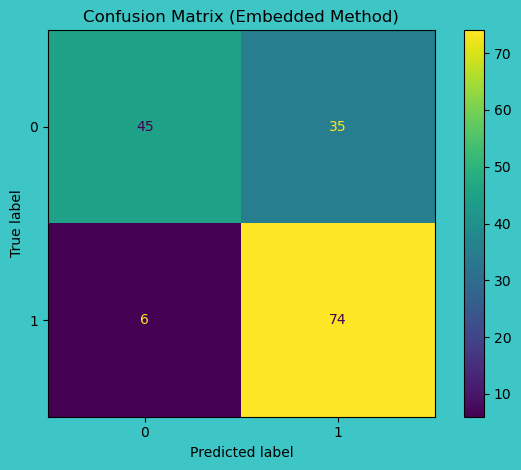

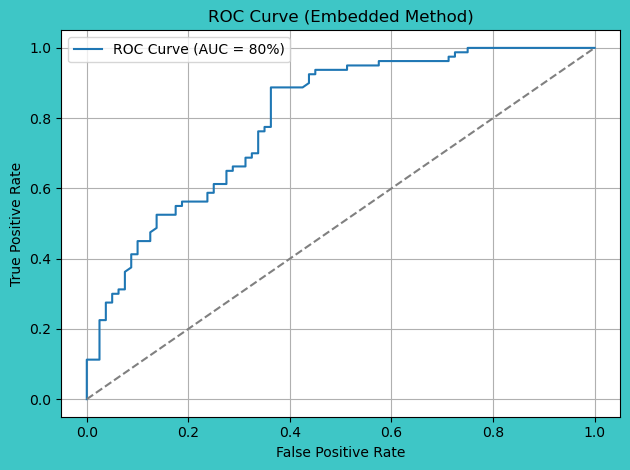

Number of patients with Anemia and Heart Disease: 297


In [9]:
#RF
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, roc_curve
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline

# Load data
data = pd.read_csv("actualdata.csv")

# Drop rows with missing target
data = data.dropna(subset=['Heartdisease'])

# Encode Gender (0=F, 1=M)
if data['Gender'].dtype == object:
    data['Gender'] = LabelEncoder().fit_transform(data['Gender'])

# Map BP, Cholesterol, Diabetes to 0/1
for col in ['BP', 'Cholesterol', 'Diabetes']:
    if data[col].dtype == object:
        data[col] = data[col].map({'Yes': 1, 'No': 0})

# Define anemia based on gender and age
def is_anemic(row):
    age = row['Age']
    hb = row['Hb']
    gender = row['Gender']
    if age < 5:
        return hb < 11.0
    elif 5 <= age <= 11:
        return hb < 11.5
    else:
        if gender == 0:
            return hb < 12.0
        elif gender == 1:
            return hb < 13.0
        else:
            return False

data['Anemia'] = data.apply(is_anemic, axis=1)
data['Anemia'] = data['Anemia'].map({True: 'Yes', False: 'No'})

# Anemia severity classification
def classify_anemia_severity(hb, age, gender):
    if age < 5:
        threshold = 11.0
    elif 5 <= age <= 11:
        threshold = 11.5
    else:
        threshold = 12.0 if gender == 0 else 13.0
    if hb < 8.0:
        return 'Severe'
    elif 8.0 <= hb <= 10.9:
        return 'Moderate'
    elif hb >= 11.0 and hb < threshold:
        return 'Mild'
    else:
        return 'None'

data['Anemia_Severity'] = data.apply(
    lambda row: classify_anemia_severity(row['Hb'], row['Age'], row['Gender']),
    axis=1
)

# Normalize selected features
features = ['RBC', 'Hb', 'MCV', 'MCH', 'MCHC', 'HCT', 'RDW-CV',
            'BP', 'Cholesterol', 'Diabetes', 'Age', 'Gender']
scaler = MinMaxScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data[features]), columns=features, index=data.index)

# Prepare features and target
X = data_scaled
y = data['Heartdisease']

print("Total dataset size:", len(data))
print("Missing target values:", data['Heartdisease'].isna().sum())

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Remove constant features
var_thresh = VarianceThreshold(threshold=0)
X_train_var = var_thresh.fit_transform(X_train)
X_test_var = var_thresh.transform(X_test)
features_kept = [feature for feature, keep in zip(features, var_thresh.get_support()) if keep]
X_train_df = pd.DataFrame(X_train_var, columns=features_kept, index=X_train.index)
X_test_df = pd.DataFrame(X_test_var, columns=features_kept, index=X_test.index)

# --- SMOTE removed ---

# --- START OF MODIFIED SECTION FOR EMBEDDED METHOD (SelectFromModel) ---
print("\n--- Embedded Method (SelectFromModel) with Tuned Random Forest ---")

pipeline_embedded = Pipeline(steps=[
    ('feature_selection', SelectFromModel(RandomForestClassifier(random_state=42))),
    ('classifier', RandomForestClassifier(random_state=42))
])

param_grid_embedded = {
    'feature_selection__threshold': ['mean', 'median', 0.05, 0.1], 
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [5, 10, None],
    'classifier__min_samples_leaf': [1, 5, 10],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__criterion': ['gini', 'entropy']
}

grid_search_embedded = GridSearchCV(
    pipeline_embedded, 
    param_grid_embedded,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

# Fit on original training data without SMOTE
grid_search_embedded.fit(X_train_df, y_train)

print("Best parameters for Embedded Method:", grid_search_embedded.best_params_)
print(f"Best ROC AUC score from GridSearchCV: {grid_search_embedded.best_score_:.4f}")

best_pipeline = grid_search_embedded.best_estimator_

selected_features_indices = best_pipeline.named_steps['feature_selection'].get_support(indices=True)
selected_features = [features_kept[i] for i in selected_features_indices]
print("Selected features with Embedded Method:", selected_features)

predicted_proba = best_pipeline.predict_proba(X_test_df)[:, 1]

predicted_proba_percent = predicted_proba * 100

threshold = 0.3
predicted_class = (predicted_proba >= threshold).astype(int)

accuracy = accuracy_score(y_test, predicted_class)
roc_auc = roc_auc_score(y_test, predicted_proba)

# Round scores to nearest integer
accuracy_rounded = round(accuracy * 100)
roc_auc_rounded = round(roc_auc * 100)

print(f"Accuracy: {accuracy_rounded}%")
print(f"ROC AUC Score: {roc_auc_rounded}%")
print("\nClassification Report:")
print(classification_report(y_test, predicted_class, zero_division=0))

predictions_df = pd.DataFrame({
    'Predicted_Class': predicted_class,
    'Predicted_Probability(%)': predicted_proba_percent
}, index=X_test.index)

temp_data_for_display = pd.read_csv("actualdata.csv").loc[X_test.index].copy()

if temp_data_for_display['Gender'].dtype == object:
    temp_data_for_display['Gender'] = LabelEncoder().fit_transform(temp_data_for_display['Gender'])

predictions_df['Cholesterol'] = temp_data_for_display['Cholesterol'].map({1: 'Yes', 0: 'No'})
predictions_df['Diabetes'] = temp_data_for_display['Diabetes'].map({1: 'Yes', 0: 'No'})
predictions_df['BP'] = temp_data_for_display['BP'].map({1: 'Yes', 0: 'No'})

predictions_df['Anemia_Severity'] = temp_data_for_display.apply(
    lambda row: classify_anemia_severity(row['Hb'], row['Age'], row['Gender']),
    axis=1
)
predictions_df['Anemia'] = temp_data_for_display.apply(is_anemic, axis=1).map({True: 'Yes', False: 'No'})

predictions_df.to_csv('predictions_rf_embedded.csv')
print("Predictions saved to predictions_rf_embedded.csv")

print("Training class distribution:\n", y_train.value_counts(normalize=True))
print("Test class distribution:\n", y_test.value_counts(normalize=True))

cm = confusion_matrix(y_test, predicted_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

fig, ax = plt.subplots()
fig.patch.set_facecolor('#3ec6c6')
ax.set_facecolor('#3ec6c6')

disp.plot(ax=ax, cmap='viridis')
plt.title("Confusion Matrix (Embedded Method)")
plt.tight_layout()
plt.show()

fpr, tpr, _ = roc_curve(y_test, predicted_proba)

plt.figure(facecolor='#3ec6c6')
ax = plt.gca()
ax.set_facecolor('white')

plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_rounded}%)')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Embedded Method)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

anemia_and_hd = data[(data['Anemia'] == 'Yes') & (data['Heartdisease'] == 1)]
count_anemia_and_hd = anemia_and_hd.shape[0]
print(f"Number of patients with Anemia and Heart Disease: {count_anemia_and_hd}")



--- Embedded Method (SelectFromModel) with Tuned SVC ---
Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best parameters for Embedded Method: {'classifier__C': 100, 'classifier__gamma': 'auto', 'classifier__kernel': 'rbf', 'feature_selection__threshold': 'median'}
Best ROC AUC score from GridSearchCV: 0.8263
Selected Features: ['RBC', 'MCV', 'MCHC', 'HCT', 'RDW-CV', 'Age']
Accuracy: 0.74
ROC AUC Score: 0.81

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.56      0.68        80
           1       0.68      0.91      0.78        80

    accuracy                           0.74       160
   macro avg       0.77      0.74      0.73       160
weighted avg       0.77      0.74      0.73       160

Predictions saved to predictions_svm_embedded.csv
Training class distribution:
 Heartdisease
0    0.5
1    0.5
Name: proportion, dtype: float64
Test class distribution:
 Heartdisease
1    0.5
0    0.5
Name: proportion, dtyp

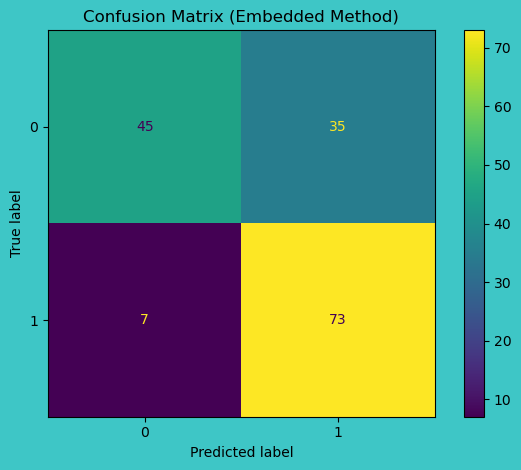

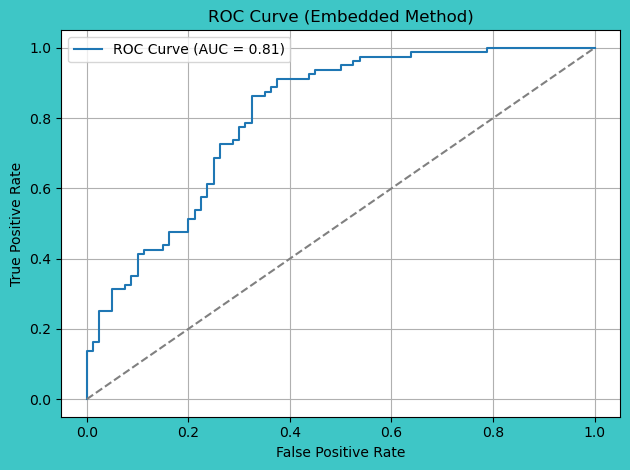

In [11]:
#SVC
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, roc_curve, ConfusionMatrixDisplay
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

# Load data
data = pd.read_csv("actualdata.csv")
data = data.dropna(subset=['Heartdisease'])

# Encode Gender (0=F, 1=M)
if data['Gender'].dtype == object:
    data['Gender'] = LabelEncoder().fit_transform(data['Gender'])

# Map BP, Cholesterol, Diabetes
for col in ['BP', 'Cholesterol', 'Diabetes']:
    if data[col].dtype == object:
        data[col] = data[col].map({'Yes': 1, 'No': 0})

# Define Anemia
def is_anemic(row):
    age = row['Age']
    hb = row['Hb']
    gender = row['Gender']
    if age < 5:
        return hb < 11.0
    elif 5 <= age <= 11:
        return hb < 11.5
    else:
        return hb < (12.0 if gender == 0 else 13.0)

data['Anemia'] = data.apply(is_anemic, axis=1).map({True: 'Yes', False: 'No'})

# Classify severity
def classify_anemia_severity(hb, age, gender):
    if age < 5:
        threshold = 11.0
    elif 5 <= age <= 11:
        threshold = 11.5
    else:
        threshold = 12.0 if gender == 0 else 13.0
    if hb < 8.0:
        return 'Severe'
    elif 8.0 <= hb <= 10.9:
        return 'Moderate'
    elif hb >= 11.0 and hb < threshold:
        return 'Mild'
    else:
        return 'None'

data['Anemia_Severity'] = data.apply(
    lambda row: classify_anemia_severity(row['Hb'], row['Age'], row['Gender']), axis=1
)

# Normalize features
features = ['RBC', 'Hb', 'MCV', 'MCH', 'MCHC', 'HCT', 'RDW-CV', 'BP', 'Cholesterol', 'Diabetes', 'Age', 'Gender']
scaler = MinMaxScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data[features]), columns=features, index=data.index)

# Target
X = data_scaled
y = data['Heartdisease']

# Split (no SMOTE)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Remove constant features
var_thresh = VarianceThreshold(threshold=0)
X_train_var = var_thresh.fit_transform(X_train)
X_test_var = var_thresh.transform(X_test)
features_kept = [f for f, keep in zip(features, var_thresh.get_support()) if keep]
X_train_df = pd.DataFrame(X_train_var, columns=features_kept, index=X_train.index)
X_test_df = pd.DataFrame(X_test_var, columns=features_kept, index=X_test.index)

# --- START OF MODIFIED SECTION FOR EMBEDDED METHOD ---
print("\n--- Embedded Method (SelectFromModel) with Tuned SVC ---")

pipeline_embedded = Pipeline(steps=[
    ('feature_selection', SelectFromModel(RandomForestClassifier(random_state=42))),
    ('classifier', SVC(probability=True, random_state=42))
])

param_grid_embedded = {
    'feature_selection__threshold': ['mean', 'median', 0.05, 0.1], 
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__kernel': ['linear', 'rbf'],
    'classifier__gamma': ['scale', 'auto']
}

grid_search_embedded = GridSearchCV(
    pipeline_embedded, 
    param_grid_embedded,
    cv=5, 
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

# Fit without SMOTE
grid_search_embedded.fit(X_train_df, y_train)

print("Best parameters for Embedded Method:", grid_search_embedded.best_params_)
print(f"Best ROC AUC score from GridSearchCV: {grid_search_embedded.best_score_:.4f}")

best_pipeline = grid_search_embedded.best_estimator_

selected_features_indices = best_pipeline.named_steps['feature_selection'].get_support(indices=True)
selected_features = [features_kept[i] for i in selected_features_indices]
print("Selected Features:", selected_features)

predicted_proba = best_pipeline.predict_proba(X_test_df)[:, 1]

# --- END OF MODIFIED SECTION ---

predicted_proba_percent = predicted_proba * 100
threshold = 0.3
predicted_class = (predicted_proba >= threshold).astype(int)

# Evaluation
accuracy = accuracy_score(y_test, predicted_class)
roc_auc = roc_auc_score(y_test, predicted_proba)

print(f"Accuracy: {accuracy:.2f}")
print(f"ROC AUC Score: {roc_auc:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, predicted_class, zero_division=0))

# Output DataFrame
predictions_df = pd.DataFrame({
    'Predicted_Class': predicted_class,
    'Predicted_Probability(%)': predicted_proba_percent
}, index=X_test.index)

temp_data_for_display = pd.read_csv("actualdata.csv").loc[X_test.index].copy()
if temp_data_for_display['Gender'].dtype == object:
    temp_data_for_display['Gender'] = LabelEncoder().fit_transform(temp_data_for_display['Gender'])

predictions_df['Cholesterol'] = temp_data_for_display['Cholesterol'].map({1: 'Yes', 0: 'No'})
predictions_df['Diabetes'] = temp_data_for_display['Diabetes'].map({1: 'Yes', 0: 'No'})
predictions_df['BP'] = temp_data_for_display['BP'].map({1: 'Yes', 0: 'No'})

predictions_df['Anemia_Severity'] = temp_data_for_display.apply(
    lambda row: classify_anemia_severity(row['Hb'], row['Age'], row['Gender']),
    axis=1
)
predictions_df['Anemia'] = temp_data_for_display.apply(is_anemic, axis=1).map({True: 'Yes', False: 'No'})

predictions_df.to_csv('predictions_svm_embedded.csv')
print("Predictions saved to predictions_svm_embedded.csv")

print("Training class distribution:\n", y_train.value_counts(normalize=True))
print("Test class distribution:\n", y_test.value_counts(normalize=True))

cm = confusion_matrix(y_test, predicted_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots()
fig.patch.set_facecolor('#3ec6c6')
ax.set_facecolor('#3ec6c6')
disp.plot(ax=ax, cmap='viridis')
plt.title("Confusion Matrix (Embedded Method)")
plt.tight_layout()
plt.show()

fpr, tpr, _ = roc_curve(y_test, predicted_proba)
plt.figure(facecolor='#3ec6c6')
ax = plt.gca()
ax.set_facecolor('white')
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Embedded Method)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



--- Embedded Method (SelectFromModel) with Tuned XGBoost ---
Fitting 5 folds for each of 2916 candidates, totalling 14580 fits


C:\Users\user\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:18:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\user\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:18:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best parameters for Embedded Method: {'classifier__colsample_bytree': 0.7, 'classifier__gamma': 0.1, 'classifier__learning_rate': 0.05, 'classifier__max_depth': 3, 'classifier__n_estimators': 100, 'classifier__subsample': 0.8, 'feature_selection__threshold': 0.1}
Best ROC AUC score from GridSearchCV: 0.8143
Selected features with Embedded Method: ['RDW-CV', 'Diabetes', 'Age']
Accuracy: 0.74
ROC AUC Score: 0.81

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.56      0.68        80
           1       0.68      0.91      0.78        80

    accuracy                           0.74       160
   macro avg       0.77      0.74      0.73       160
weighted avg       0.77      0.74      0.73       160

Predictions saved to predictions_xgboost_embedded.csv

Count of samples by Anemia Severity and Predicted Probability Range:
Probability_Range  1-20%  21-40%  41-60%  61-80%  81-100%
Anemia_Severity                                      

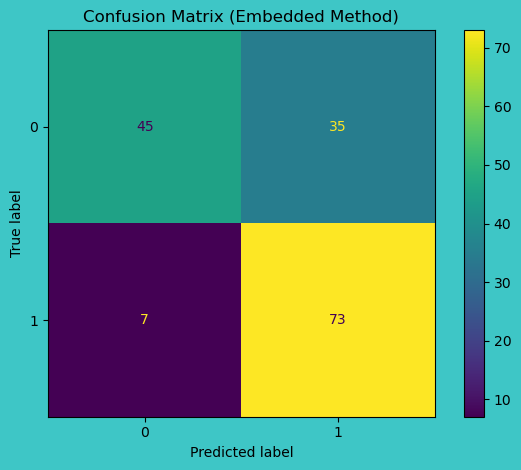

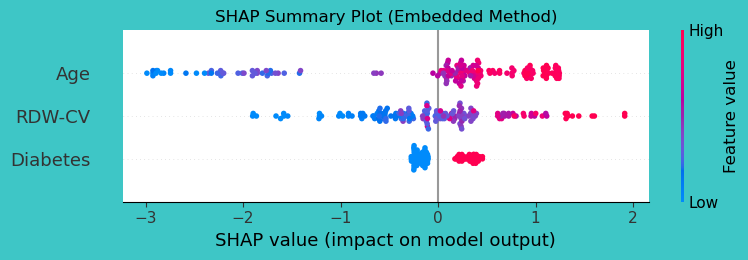

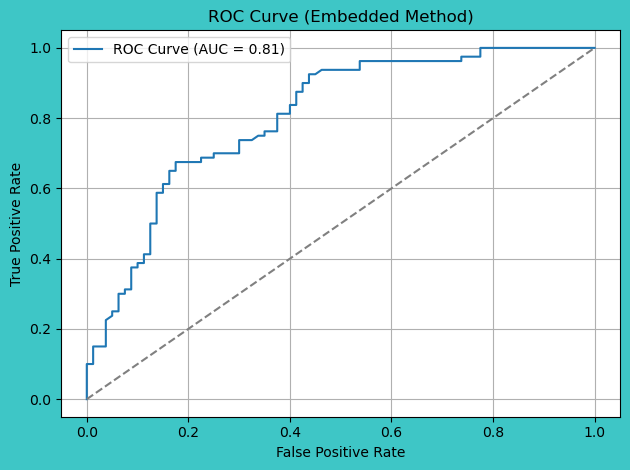

Number of patients with Anemia and Heart Disease: 297


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, roc_curve, ConfusionMatrixDisplay
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from xgboost import XGBClassifier
import shap
from sklearn.pipeline import Pipeline

# Load data
data = pd.read_csv("actualdata.csv")
data = data.dropna(subset=['Heartdisease'])

# Encode Gender (0=F, 1=M)
if data['Gender'].dtype == object:
    data['Gender'] = LabelEncoder().fit_transform(data['Gender'])

# Map BP, Cholesterol, Diabetes
for col in ['BP', 'Cholesterol', 'Diabetes']:
    if data[col].dtype == object:
        data[col] = data[col].map({'Yes': 1, 'No': 0})

# Define Anemia
def is_anemic(row):
    age = row['Age']
    hb = row['Hb']
    gender = row['Gender']
    if age < 5:
        return hb < 11.0
    elif 5 <= age <= 11:
        return hb < 11.5
    else:
        return hb < (12.0 if gender == 0 else 13.0)

data['Anemia'] = data.apply(is_anemic, axis=1).map({True: 'Yes', False: 'No'})

# Classify severity
def classify_anemia_severity(hb, age, gender):
    if age < 5:
        threshold = 11.0
    elif 5 <= age <= 11:
        threshold = 11.5
    else:
        threshold = 12.0 if gender == 0 else 13.0
    if hb < 8.0:
        return 'Severe'
    elif 8.0 <= hb <= 10.9:
        return 'Moderate'
    elif hb >= 11.0 and hb < threshold:
        return 'Mild'
    else:
        return 'None'

data['Anemia_Severity'] = data.apply(
    lambda row: classify_anemia_severity(row['Hb'], row['Age'], row['Gender']), axis=1
)

# Normalize features
features = ['RBC', 'Hb', 'MCV', 'MCH', 'MCHC', 'HCT', 'RDW-CV', 'BP', 'Cholesterol', 'Diabetes', 'Age', 'Gender']
scaler = MinMaxScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data[features]), columns=features, index=data.index)

# Target
X = data_scaled
y = data['Heartdisease']

# Split (no SMOTE)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Remove constant features
var_thresh = VarianceThreshold(threshold=0)
X_train_var = var_thresh.fit_transform(X_train)
X_test_var = var_thresh.transform(X_test)
features_kept = [f for f, keep in zip(features, var_thresh.get_support()) if keep]
X_train_df = pd.DataFrame(X_train_var, columns=features_kept, index=X_train.index)
X_test_df = pd.DataFrame(X_test_var, columns=features_kept, index=X_test.index)

# --- START OF MODIFIED SECTION FOR EMBEDDED METHOD ---
print("\n--- Embedded Method (SelectFromModel) with Tuned XGBoost ---")

pipeline_embedded = Pipeline(steps=[
    ('feature_selection', SelectFromModel(
        XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    )),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

param_grid_embedded = {
    'feature_selection__threshold': ['mean', 'median', 0.05, 0.1],
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.05, 0.1, 0.15],
    'classifier__subsample': [0.7, 0.8, 0.9],
    'classifier__colsample_bytree': [0.7, 0.8, 0.9],
    'classifier__gamma': [0, 0.1, 0.2]
}

grid_search_embedded = GridSearchCV(
    pipeline_embedded,
    param_grid_embedded,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid_search_embedded.fit(X_train_df, y_train)

print("Best parameters for Embedded Method:", grid_search_embedded.best_params_)
print(f"Best ROC AUC score from GridSearchCV: {grid_search_embedded.best_score_:.4f}")

best_pipeline = grid_search_embedded.best_estimator_

selected_features_indices = best_pipeline.named_steps['feature_selection'].get_support(indices=True)
selected_features = [features_kept[i] for i in selected_features_indices]
print("Selected features with Embedded Method:", selected_features)

predicted_proba = best_pipeline.predict_proba(X_test_df)[:, 1]

# --- END OF MODIFIED SECTION ---

predicted_proba_percent = predicted_proba * 100
threshold = 0.3
predicted_class = (predicted_proba >= threshold).astype(int)

# Evaluation
accuracy = accuracy_score(y_test, predicted_class)
roc_auc = roc_auc_score(y_test, predicted_proba)

print(f"Accuracy: {accuracy:.2f}")
print(f"ROC AUC Score: {roc_auc:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, predicted_class, zero_division=0))

# Output DataFrame
predictions_df = pd.DataFrame({
    'Predicted_Class': predicted_class,
    'Predicted_Probability(%)': predicted_proba_percent
}, index=X_test.index)

temp_data_for_display = pd.read_csv("actualdata.csv").loc[X_test.index].copy()

if temp_data_for_display['Gender'].dtype == object:
    temp_data_for_display['Gender'] = LabelEncoder().fit_transform(temp_data_for_display['Gender'])

predictions_df['Cholesterol'] = temp_data_for_display['Cholesterol'].map({1: 'Yes', 0: 'No'})
predictions_df['Diabetes'] = temp_data_for_display['Diabetes'].map({1: 'Yes', 0: 'No'})
predictions_df['BP'] = temp_data_for_display['BP'].map({1: 'Yes', 0: 'No'})

predictions_df['Anemia_Severity'] = temp_data_for_display.apply(
    lambda row: classify_anemia_severity(row['Hb'], row['Age'], row['Gender']),
    axis=1
)
predictions_df['Anemia'] = temp_data_for_display.apply(is_anemic, axis=1).map({True: 'Yes', False: 'No'})

bins = [1, 20, 40, 60, 80, 100]
labels = ['1-20%', '21-40%', '41-60%', '61-80%', '81-100%']
predictions_df['Probability_Range'] = pd.cut(predictions_df['Predicted_Probability(%)'], bins=bins, labels=labels, include_lowest=True)
predictions_df.to_csv('predictions_xgboost_embedded.csv')
print("Predictions saved to predictions_xgboost_embedded.csv")

print("\nCount of samples by Anemia Severity and Predicted Probability Range:")
print(pd.crosstab(predictions_df['Anemia_Severity'], predictions_df['Probability_Range']))
print("Training class distribution:\n", y_train.value_counts(normalize=True))
print("Test class distribution:\n", y_test.value_counts(normalize=True))

# Confusion matrix
cm = confusion_matrix(y_test, predicted_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots()
fig.patch.set_facecolor('#3ec6c6')
ax.set_facecolor('#3ec6c6')
disp.plot(ax=ax, cmap='viridis')
plt.title("Confusion Matrix (Embedded Method)")
plt.tight_layout()
plt.show()

# SHAP for Tuned XGBoost
final_model = best_pipeline.named_steps['classifier']
explainer = shap.TreeExplainer(final_model)

X_test_selected_by_pipeline = best_pipeline.named_steps['feature_selection'].transform(X_test_df)

shap_values = explainer.shap_values(X_test_selected_by_pipeline)

if isinstance(shap_values, list):
    shap_values = shap_values[1]

shap.summary_plot(shap_values, features=X_test_selected_by_pipeline, feature_names=selected_features, show=False)

fig = plt.gcf()
ax = plt.gca()
fig.patch.set_facecolor('#3ec6c6')
ax.set_facecolor('white')
plt.title("SHAP Summary Plot (Embedded Method)")
plt.tight_layout()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, predicted_proba)
plt.figure(facecolor='#3ec6c6')
ax = plt.gca()
ax.set_facecolor('white')
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Embedded Method)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Count patients with Anemia and Heart Disease
anemia_and_hd = data[(data['Anemia'] == 'Yes') & (data['Heartdisease'] == 1)]
print(f"Number of patients with Anemia and Heart Disease: {anemia_and_hd.shape[0]}")


Selected Features (Embedded Method): ['RBC', 'MCV', 'MCH', 'MCHC', 'HCT', 'RDW-CV', 'Age']
Best Threshold: 0.40, Best F1 Score: 0.7869

Final Ensemble Model Performance:
Accuracy: 75.62%
ROC AUC Score: 81.31%

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.61      0.72        80
           1       0.70      0.90      0.79        80

    accuracy                           0.76       160
   macro avg       0.78      0.76      0.75       160
weighted avg       0.78      0.76      0.75       160

Predictions saved to 'ensemble_embedded_predictions.csv'


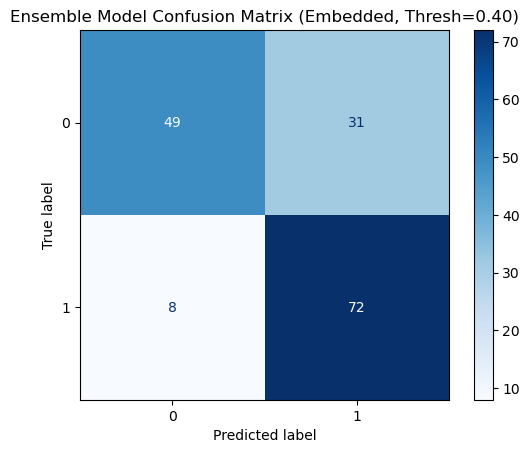

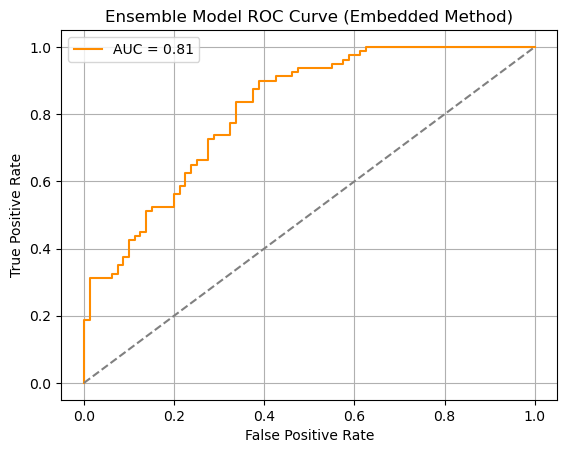

In [1]:
#ensemble
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, f1_score
import warnings
warnings.filterwarnings('ignore')

# Load and clean data
data = pd.read_csv("actualdata.csv")
data = data.dropna(subset=['Heartdisease'])

# Encode Gender
data['Gender'] = LabelEncoder().fit_transform(data['Gender'])

# Encode BP, Cholesterol, Diabetes
for col in ['BP', 'Cholesterol', 'Diabetes']:
    if data[col].dtype == object:
        data[col] = data[col].map({'Yes': 1, 'No': 0})

# Anemia Detection
def is_anemic(row):
    age, hb, gender = row['Age'], row['Hb'], row['Gender']
    if age < 5:
        return hb < 11.0
    elif 5 <= age <= 11:
        return hb < 11.5
    else:
        return hb < (12.0 if gender == 0 else 13.0)

data['Anemia'] = data.apply(is_anemic, axis=1)
data['Anemia'] = data['Anemia'].map({True: 'Yes', False: 'No'})

# Anemia Severity
def classify_anemia_severity(hb, age, gender):
    threshold = 11.0 if age < 5 else 11.5 if age <= 11 else (12.0 if gender == 0 else 13.0)
    if hb < 8.0:
        return 'Severe'
    elif 8.0 <= hb <= 10.9:
        return 'Moderate'
    elif 11.0 <= hb < threshold:
        return 'Mild'
    return 'None'

data['Anemia_Severity'] = data.apply(
    lambda row: classify_anemia_severity(row['Hb'], row['Age'], row['Gender']),
    axis=1
)

# Select base features
base_features = ['RBC', 'Hb', 'MCV', 'MCH', 'MCHC', 'HCT', 'RDW-CV',
                 'BP', 'Cholesterol', 'Diabetes', 'Age', 'Gender']
X = data[base_features]
y = data['Heartdisease']

# Scale only for LR and SVM
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=base_features)


# --- START OF MODIFIED SECTION FOR EMBEDDED METHOD ---
# Use a RandomForestClassifier to get feature importances
rf_selector = RandomForestClassifier(n_estimators=100, random_state=42)
rf_selector.fit(X_scaled, y)

# Use SelectFromModel to select features based on importance scores
selector = SelectFromModel(rf_selector, threshold='mean', prefit=True)
X_selected = selector.transform(X_scaled)
selected_features = [base_features[i] for i in selector.get_support(indices=True)]
print(f"Selected Features (Embedded Method): {selected_features}")
# --- END OF MODIFIED SECTION ---


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y)

# Tune models
param_lr = {'C': [0.01, 0.1, 1, 10], 'solver': ['liblinear']}
param_rf = {'n_estimators': [100, 150], 'max_depth': [None, 5, 10], 'min_samples_split': [2, 5]}
param_svc = {'C': [0.1, 1, 2], 'kernel': ['rbf'], 'gamma': ['scale', 'auto']}
param_lgbm = {'n_estimators': [100, 150, 200], 'learning_rate': [0.01, 0.05, 0.1], 'max_depth': [3, 5, 7]}
param_dt = {'max_depth': [None, 5, 10, 15], 'min_samples_split': [2, 5, 10], 'criterion': ['gini', 'entropy']}

lr_search = RandomizedSearchCV(LogisticRegression(max_iter=1000), param_lr, cv=3, n_iter=4,
                               scoring='roc_auc', random_state=42, n_jobs=-1)
rf_search = RandomizedSearchCV(RandomForestClassifier(random_state=42), param_rf, cv=3, n_iter=5,
                               scoring='roc_auc', random_state=42, n_jobs=-1)
svm_search = RandomizedSearchCV(SVC(probability=True, random_state=42), param_svc, cv=3, n_iter=5,
                                scoring='roc_auc', random_state=42, n_jobs=-1)
lgbm_search = RandomizedSearchCV(LGBMClassifier(random_state=42, verbose=-1), param_lgbm, cv=3, n_iter=5,
                                 scoring='roc_auc', random_state=42, n_jobs=-1)
dt_search = RandomizedSearchCV(DecisionTreeClassifier(random_state=42), param_dt, cv=3, n_iter=5,
                               scoring='roc_auc', random_state=42, n_jobs=-1)

lr_search.fit(X_train, y_train)
rf_search.fit(X_train, y_train)
svm_search.fit(X_train, y_train)
lgbm_search.fit(X_train, y_train)
dt_search.fit(X_train, y_train)

# XGBoost without early stopping
xgb_model = XGBClassifier(
    eval_metric='logloss',
    random_state=42,
    n_estimators=150,
    learning_rate=0.1,
    max_depth=4,
    subsample=0.8
)
xgb_model.fit(X_train, y_train)

# Ensemble model
ensemble_model = VotingClassifier(
    estimators=[
        ('lr', lr_search.best_estimator_),
        ('rf', rf_search.best_estimator_),
        ('svm', svm_search.best_estimator_),
        ('xgb', xgb_model),
        ('lgbm', lgbm_search.best_estimator_),
        ('dt', dt_search.best_estimator_)
    ],
    voting='soft',
    n_jobs=-1
)
ensemble_model.fit(X_train, y_train)

# Predict probabilities and find best threshold
ensemble_proba = ensemble_model.predict_proba(X_test)[:, 1]

def find_best_threshold(y_true, y_probs):
    best_thresh = 0.5
    best_f1 = 0
    for thresh in np.linspace(0.1, 0.9, 81):
        preds = (y_probs >= thresh).astype(int)
        score = f1_score(y_true, preds)
        if score > best_f1:
            best_f1 = score
            best_thresh = thresh
    return best_thresh, best_f1

best_threshold, best_f1 = find_best_threshold(y_test, ensemble_proba)
print(f"Best Threshold: {best_threshold:.2f}, Best F1 Score: {best_f1:.4f}")

# Final predictions
ensemble_preds = (ensemble_proba >= best_threshold).astype(int)

# Evaluation
accuracy = accuracy_score(y_test, ensemble_preds)
roc_auc = roc_auc_score(y_test, ensemble_proba)
print(f"\nFinal Ensemble Model Performance:")
print(f"Accuracy: {accuracy*100:.2f}%")
print(f"ROC AUC Score: {roc_auc*100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, ensemble_preds, zero_division=0))

# Save results
results_df = pd.DataFrame({
    'True_Label': y_test,
    'Anemia_Severity': data.loc[y_test.index, 'Anemia_Severity'],
    'Predicted_Probability(%)': ensemble_proba * 100,
    'Predicted_Class': ensemble_preds
}, index=y_test.index)
results_df.to_csv('ensemble_embedded_predictions.csv')
print("Predictions saved to 'ensemble_embedded_predictions.csv'")

# Confusion Matrix
cm = confusion_matrix(y_test, ensemble_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title(f"Ensemble Model Confusion Matrix (Embedded, Thresh={best_threshold:.2f})")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, ensemble_proba)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Ensemble Model ROC Curve (Embedded Method)')
plt.legend()
plt.grid(True)
plt.show()

Selected Features using SelectFromModel: ['RBC', 'MCV', 'MCH', 'HCT', 'RDW-CV', 'Age']
Tuning Logistic Regression...
Tuning SVM...

Cross-Validation Accuracy Scores (Ensemble): [0.7109375 0.6796875 0.765625  0.765625  0.7890625]
Mean CV Accuracy (Ensemble): 74.22%
Standard Deviation: 4.04%
Best Threshold: 0.36, Best F1 Score: 0.7935

Final Ensemble Model Performance:
Accuracy: 76.25%
ROC AUC Score: 80.94%

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.61      0.72        80
           1       0.70      0.91      0.79        80

    accuracy                           0.76       160
   macro avg       0.79      0.76      0.76       160
weighted avg       0.79      0.76      0.76       160

Predictions saved to 'ensemble_model_predictions_anemia_optimized.csv'


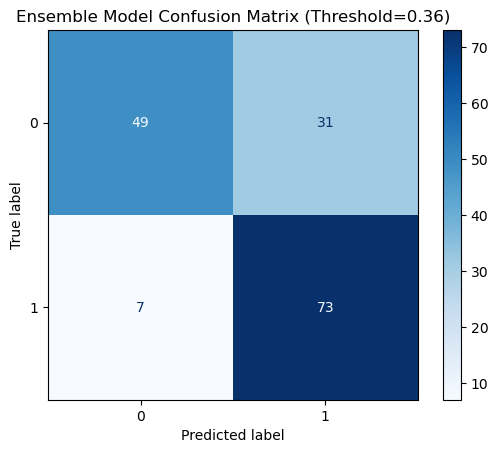

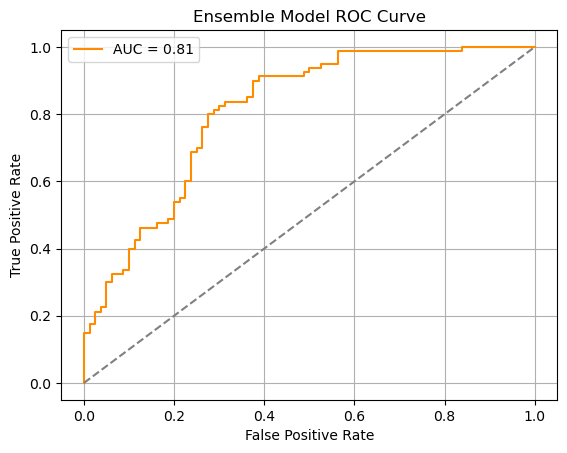

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, f1_score
import warnings
warnings.filterwarnings('ignore')

# Load and clean data
data = pd.read_csv("actualdata.csv")
data = data.dropna(subset=['Heartdisease'])

# Encode Gender
data['Gender'] = LabelEncoder().fit_transform(data['Gender'])

# Encode BP, Cholesterol, Diabetes
for col in ['BP', 'Cholesterol', 'Diabetes']:
    if data[col].dtype == object:
        data[col] = data[col].map({'Yes': 1, 'No': 0})

# Anemia Detection
def is_anemic(row):
    age, hb, gender = row['Age'], row['Hb'], row['Gender']
    if age < 5:
        return hb < 11.0
    elif 5 <= age <= 11:
        return hb < 11.5
    else:
        return hb < (12.0 if gender == 0 else 13.0)

data['Anemia'] = data.apply(is_anemic, axis=1)
data['Anemia'] = data['Anemia'].map({True: 'Yes', False: 'No'})

# Anemia Severity
def classify_anemia_severity(hb, age, gender):
    threshold = 11.0 if age < 5 else 11.5 if age <= 11 else (12.0 if gender == 0 else 13.0)
    if hb < 8.0:
        return 'Severe'
    elif 8.0 <= hb <= 10.9:
        return 'Moderate'
    elif 11.0 <= hb < threshold:
        return 'Mild'
    return 'None'

data['Anemia_Severity'] = data.apply(
    lambda row: classify_anemia_severity(row['Hb'], row['Age'], row['Gender']),
    axis=1
)

# Select base features
base_features = ['RBC', 'Hb', 'MCV', 'MCH', 'MCHC', 'HCT', 'RDW-CV',
                 'BP', 'Cholesterol', 'Diabetes', 'Age', 'Gender']
X = data[base_features]
y = data['Heartdisease']

# Scale features
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=base_features)

# Feature selection using SelectFromModel with RandomForestClassifier
selector_model = RandomForestClassifier(n_estimators=100, random_state=42)
selector_model.fit(X_scaled, y)

selector = SelectFromModel(estimator=selector_model, prefit=True, threshold='median')
X_selected = selector.transform(X_scaled)
selected_features = list(X_scaled.columns[selector.get_support()])

print(f"Selected Features using SelectFromModel: {selected_features}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y)

# Hyperparameter grids
param_lr = {'C': [0.01, 0.1, 1, 10], 'solver': ['liblinear']}
param_svc = {'C': [0.1, 1, 2], 'kernel': ['rbf'], 'gamma': ['scale', 'auto']}

# Initialize models and RandomizedSearchCV for tuning
lr_search = RandomizedSearchCV(LogisticRegression(max_iter=1000), param_lr, cv=3, n_iter=4,
                               scoring='roc_auc', random_state=42, n_jobs=-1)
svm_search = RandomizedSearchCV(SVC(probability=True, random_state=42), param_svc, cv=3, n_iter=5,
                                scoring='roc_auc', random_state=42, n_jobs=-1)

# Fit tunings
print("Tuning Logistic Regression...")
lr_search.fit(X_train, y_train)

print("Tuning SVM...")
svm_search.fit(X_train, y_train)

# Build ensemble with tuned Logistic Regression and SVM
ensemble_model = VotingClassifier(
    estimators=[
        ('lr', lr_search.best_estimator_),
        ('svm', svm_search.best_estimator_),
    ],
    voting='soft',
    n_jobs=-1
)

# Fit ensemble
ensemble_model.fit(X_train, y_train)

# Cross-validation accuracy on training set
cv_scores = cross_val_score(ensemble_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"\nCross-Validation Accuracy Scores (Ensemble): {cv_scores}")
print(f"Mean CV Accuracy (Ensemble): {cv_scores.mean()*100:.2f}%")
print(f"Standard Deviation: {cv_scores.std()*100:.2f}%")

# Predict probabilities on test set
ensemble_proba = ensemble_model.predict_proba(X_test)[:, 1]

# Find best threshold by maximizing F1 score
def find_best_threshold(y_true, y_probs):
    best_thresh = 0.5
    best_f1 = 0
    for thresh in np.linspace(0.1, 0.9, 81):
        preds = (y_probs >= thresh).astype(int)
        score = f1_score(y_true, preds)
        if score > best_f1:
            best_f1 = score
            best_thresh = thresh
    return best_thresh, best_f1

best_threshold, best_f1 = find_best_threshold(y_test, ensemble_proba)
print(f"Best Threshold: {best_threshold:.2f}, Best F1 Score: {best_f1:.4f}")

# Final predictions using best threshold
ensemble_preds = (ensemble_proba >= best_threshold).astype(int)

# Evaluate final model
accuracy = accuracy_score(y_test, ensemble_preds)
roc_auc = roc_auc_score(y_test, ensemble_proba)
print(f"\nFinal Ensemble Model Performance:")
print(f"Accuracy: {accuracy*100:.2f}%")
print(f"ROC AUC Score: {roc_auc*100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, ensemble_preds, zero_division=0))

# Save predictions with additional info
results_df = pd.DataFrame({
    'True_Label': y_test,
    'Anemia_Severity': data.loc[y_test.index, 'Anemia_Severity'],
    'Predicted_Probability(%)': ensemble_proba * 100,
    'Predicted_Class': ensemble_preds
}, index=y_test.index)
results_df.to_csv('ensemble_model_predictions_anemia_optimized.csv')
print("Predictions saved to 'ensemble_model_predictions_anemia_optimized.csv'")

# Confusion Matrix plot
cm = confusion_matrix(y_test, ensemble_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title(f"Ensemble Model Confusion Matrix (Threshold={best_threshold:.2f})")
plt.show()

# ROC Curve plot
fpr, tpr, _ = roc_curve(y_test, ensemble_proba)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Ensemble Model ROC Curve')
plt.legend()
plt.grid(True)
plt.show()


Features selected by SelectFromModel: ['HCT', 'RDW-CV', 'Age']

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best hyperparameters found: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Best cross-validation ROC AUC: 0.8129

Cross-Validation Accuracy Scores: ['71.88%', '67.97%', '75.00%', '75.00%', '77.34%']
Mean CV Accuracy: 73.44%
Standard Deviation: 3.24%
Accuracy: 71.88%
ROC AUC Score: 78.88%

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.69      0.71        80
           1       0.71      0.75      0.73        80

    accuracy                           0.72       160
   macro avg       0.72      0.72      0.72       160
weighted avg       0.72      0.72      0.72       160


Predictions saved to predictions_tuned_logistic_selectfrommodel.csv

Training class distribution:
 Heartdisease
0    0.5
1    0.5
Name: proportion, dtype: float64
Test class distribution:
 Heartdisease
1    0.5
0    0.5
Name: pro

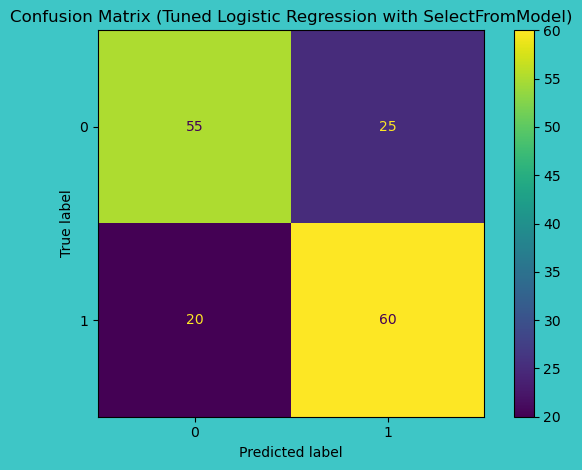

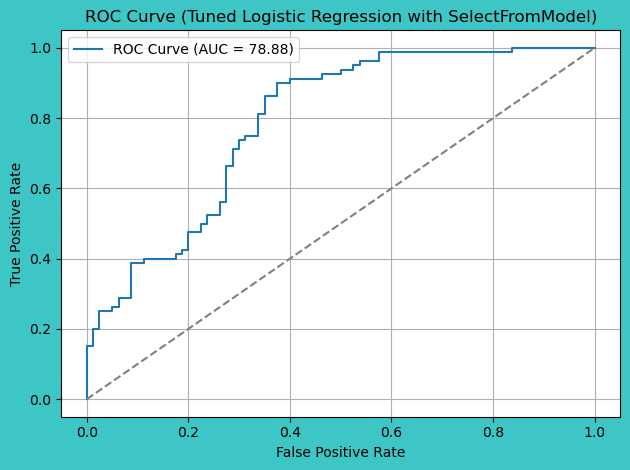

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve
from sklearn.feature_selection import VarianceThreshold, SelectFromModel

# Load data
data = pd.read_csv("actualdata.csv")
data = data.dropna(subset=['Heartdisease'])

# Encode Gender (0=F, 1=M)
if data['Gender'].dtype == object:
    data['Gender'] = LabelEncoder().fit_transform(data['Gender'])

# Map BP, Cholesterol, Diabetes to 0/1
for col in ['BP', 'Cholesterol', 'Diabetes']:
    if data[col].dtype == object:
        data[col] = data[col].map({'Yes': 1, 'No': 0})

# Anemia logic
def is_anemic(row):
    age, hb, gender = row['Age'], row['Hb'], row['Gender']
    if age < 5:
        return hb < 11.0
    elif 5 <= age <= 11:
        return hb < 11.5
    else:
        return hb < (12.0 if gender == 0 else 13.0)

data['Anemia'] = data.apply(is_anemic, axis=1)
data['Anemia'] = data['Anemia'].map({True: 'Yes', False: 'No'})

def classify_anemia_severity(hb, age, gender):
    threshold = 11.0 if age < 5 else 11.5 if age <= 11 else (12.0 if gender == 0 else 13.0)
    if hb < 8.0:
        return 'Severe'
    elif 8.0 <= hb <= 10.9:
        return 'Moderate'
    elif 11.0 <= hb < threshold:
        return 'Mild'
    return 'None'

data['Anemia_Severity'] = data.apply(
    lambda row: classify_anemia_severity(row['Hb'], row['Age'], row['Gender']),
    axis=1
)

# Feature selection and scaling
features = ['RBC', 'Hb', 'MCV', 'MCH', 'MCHC', 'HCT', 'RDW-CV',
            'BP', 'Cholesterol', 'Diabetes', 'Age', 'Gender']
scaler = MinMaxScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data[features]), columns=features, index=data.index)

X = data_scaled
y = data['Heartdisease']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Remove constant features
var_thresh = VarianceThreshold(threshold=0)
X_train_var = var_thresh.fit_transform(X_train)
X_test_var = var_thresh.transform(X_test)

features_kept = [feature for feature, keep in zip(features, var_thresh.get_support()) if keep]
X_train_var_df = pd.DataFrame(X_train_var, columns=features_kept, index=X_train.index)
X_test_var_df = pd.DataFrame(X_test_var, columns=features_kept, index=X_test.index)

# --- Embedded feature selection using SelectFromModel ---
from sklearn.feature_selection import SelectFromModel

embed_model = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000, random_state=42)
selector = SelectFromModel(embed_model, threshold='mean')  # You can adjust threshold as needed

selector.fit(X_train_var_df, y_train)
X_train_selected = selector.transform(X_train_var_df)
X_test_selected = selector.transform(X_test_var_df)

selected_features = [features_kept[i] for i in selector.get_support(indices=True)]
print(f"Features selected by SelectFromModel: {selected_features}\n")

X_train_selected_df = pd.DataFrame(X_train_selected, columns=selected_features, index=X_train.index)
X_test_selected_df = pd.DataFrame(X_test_selected, columns=selected_features, index=X_test.index)

# --- Hyperparameter tuning with GridSearchCV ---
model = LogisticRegression(max_iter=1000, random_state=42)

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_selected_df, y_train)

print("Best hyperparameters found:", grid_search.best_params_)
print(f"Best cross-validation ROC AUC: {grid_search.best_score_:.4f}")

best_model = grid_search.best_estimator_

# Cross-Validation Accuracy Scores on training set with best model
cv_accuracy_scores = cross_val_score(best_model, X_train_selected_df, y_train, cv=5, scoring='accuracy', n_jobs=-1)
cv_accuracy_percent = [f"{score * 100:.2f}%" for score in cv_accuracy_scores]
mean_cv_accuracy = np.mean(cv_accuracy_scores) * 100
std_cv_accuracy = np.std(cv_accuracy_scores) * 100

print(f"\nCross-Validation Accuracy Scores: {cv_accuracy_percent}")
print(f"Mean CV Accuracy: {mean_cv_accuracy:.2f}%")
print(f"Standard Deviation: {std_cv_accuracy:.2f}%")

# Predict on test set
predicted_proba = best_model.predict_proba(X_test_selected_df)[:, 1]
predicted_class = (predicted_proba >= 0.5).astype(int)

# Evaluation on test set
accuracy = accuracy_score(y_test, predicted_class) * 100
roc_auc = roc_auc_score(y_test, predicted_proba) * 100

print(f"Accuracy: {accuracy:.2f}%")
print(f"ROC AUC Score: {roc_auc:.2f}%")

print("\nClassification Report:")
print(classification_report(y_test, predicted_class, zero_division=0))

# Save predictions with original info
predictions_df = pd.DataFrame({
    'Predicted_Class': predicted_class,
    'Predicted_Probability(%)': predicted_proba * 100
}, index=X_test.index)

predictions_df['Cholesterol'] = data.loc[X_test.index, 'Cholesterol'].map({1: 'Yes', 0: 'No'})
predictions_df['Diabetes'] = data.loc[X_test.index, 'Diabetes'].map({1: 'Yes', 0: 'No'})
predictions_df['BP'] = data.loc[X_test.index, 'BP'].map({1: 'Yes', 0: 'No'})
predictions_df['Anemia_Severity'] = data.loc[X_test.index, 'Anemia_Severity']
predictions_df['Anemia'] = data.loc[X_test.index, 'Anemia']

predictions_df.to_csv('predictions_tuned_logistic_selectfrommodel.csv')
print("\nPredictions saved to predictions_tuned_logistic_selectfrommodel.csv")

# Class distribution
print("\nTraining class distribution:\n", y_train.value_counts(normalize=True))
print("Test class distribution:\n", y_test.value_counts(normalize=True))

# Confusion matrix plot
cm = confusion_matrix(y_test, predicted_class)
fig, ax = plt.subplots()
fig.patch.set_facecolor('#3ec6c6')
ax.set_facecolor('#3ec6c6')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax, cmap='viridis')
plt.title("Confusion Matrix (Tuned Logistic Regression with SelectFromModel)")
plt.tight_layout()
plt.show()

# ROC Curve plot
fpr, tpr, _ = roc_curve(y_test, predicted_proba)
plt.figure(facecolor='#3ec6c6')
ax = plt.gca()
ax.set_facecolor('white')
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Tuned Logistic Regression with SelectFromModel)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
